<a href="https://colab.research.google.com/github/syllerim/deep-learning-skin-diagnosis/blob/main/2_HAM10000_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 **Deep Learning - Diagnosis of Pigmented Skin Lesion using The HAM10000** 🧠

Use Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 🧑‍🍳 **Set up paths to dataset files stored in Google Drive** 🗄️

In [63]:
# define base directory where the dataset files are stored in Google Drive
DATA_DIR = '/content/drive/MyDrive/KeepCoding/Bootcamp_AI/DeepLearning'

#metadata
PATH_METADATA_DEV2 = f'{DATA_DIR}/HAM10000_metadata_dev2.csv'
PATH_METADATA_TEST2 = f'{DATA_DIR}/HAM10000_metadata_test2.csv'

# indexes
PATH_METADATA_TRAIN_IDX = f'{DATA_DIR}/HAM_metadata_train_idx.npy'
PATH_METADATA_VAL_IDX = f'{DATA_DIR}/HAM_metadata_val_idx.npy'

# images
PATH_IMAGES = f'{DATA_DIR}/hnmist_28_28_RGB.csv'
PATH_IMAGES_DEV = f'{DATA_DIR}/hnmist_28_28_RGB_dev.csv'
PATH_IMAGES_TEST = f'{DATA_DIR}/hnmist_28_28_RGB_test.csv'

# embeddings
PATH_EMBEDDINGS_TRAIN = f'{DATA_DIR}/hnmist_embeddings_train.csv'
PATH_EMBEDDINGS_VAL = f'{DATA_DIR}/hnmist_embeddings_val.csv'
PATH_EMBEDDINGS_TEST = f'{DATA_DIR}/hnmist_embeddings_test.csv'

# models
PATH_IMAGE_MODEL = f'{DATA_DIR}/HAM_image_model.keras'
PATH_IMAGE_MODEL2 = f'{DATA_DIR}/HAM_image_model2.keras'
PATH_IMAGE_MODEL3 = f'{DATA_DIR}/HAM_image_model3.keras'

# images_final_slices
PATH_IMAGES_FINAL_SLICES_TRAIN = f'{DATA_DIR}/hnmist_final_slices_train.csv'
PATH_IMAGES_FINAL_SLICES_VAL = f'{DATA_DIR}/hnmist_final_slices_val.csv'
PATH_IMAGES_FINAL_SLICES_TEST = f'{DATA_DIR}/hnmist_final_slices_test.csv'

In [5]:
# import the main libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np

from keras.saving import save_model

from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## ✂️ **Split Images Development: Training / Validation**

In [7]:
# load indexes saved on previous metadata split
train_metadata_idx = np.load(PATH_METADATA_TRAIN_IDX, allow_pickle=True)
val_metadata_idx = np.load(PATH_METADATA_VAL_IDX, allow_pickle=True)

In [8]:
# load only the development images and work with them
df_images_dev = pd.read_csv(PATH_IMAGES_DEV, sep=',')

In [9]:
# split dev into train and test sets
X_train_img = df_images_dev.loc[train_metadata_idx]
X_val_img = df_images_dev.loc[val_metadata_idx]

print(f'Shape images dev: {df_images_dev.shape}')
print(f'Shape images train: {X_train_img.shape}')
print(f'Shape images val: {X_val_img.shape}')

Shape images dev: (7974, 2352)
Shape images train: (6379, 2352)
Shape images val: (1595, 2352)


In [10]:
assert all(train_metadata_idx == X_train_img.index)
assert all(val_metadata_idx == X_val_img.index)

## 🧩 **Obtain Embeddings**

### **Methods**

In [11]:
def preprocess_and_resize_images(
    df_images,
    size_from=28,
    size_to=224,
    channels=3):
    """
    Reshapes and resizes images stored as flattened arrays in a DataFrame.

    Parameters:
    - image_df: DataFrame with shape (N, H*W*C)
    - original_shape: tuple of (height, width, channels) for original image
    - target_shape: tuple of (new_height, new_width)

    Returns:
    - Tensor with shape (N, target_height, target_width, channels)
    """
    images = df_images.values.reshape(-1, size_from, size_from, channels)
    resized_images = tf.image.resize(images, (size_to, size_to))
    return resized_images

In [12]:
def predict_images(
    model_name,
    pooling,
    X_dataset_img,
    batch_size,
    path):
  """
    Extracts feature embeddings from a pre-trained CNN
    (EfficientNetB0 or ResNet50) using transfer learning, and saves them to a
    CSV file.

    Parameters:
    ----------
    model_name : str
        Name of the model to use ('efficient' or 'resnet').

    pooling : str
        Type of pooling to apply at the end of the network ('avg' or 'max').

    X_dataset_img : np.ndarray
        Array of resized input images.

    batch_size : int
        Batch size to use during prediction.

    path : str
        File path where the embeddings (CSV format) will be saved.

    Returns:
    -------
    None
        Saves embeddings to disk and prints model summary.
    """
  MODELS = {
    'efficient': EfficientNetB0,
    'resnet': ResNet50
  }

  MODELS_INPUT_SHAPE = {
    'efficient': (224, 224, 3),
    'resnet': (224, 224, 3)
  }

  Network = MODELS[model_name]
  Network_input_shape = MODELS_INPUT_SHAPE[model_name]

  # load the model without the classification part (only for embeddings)
  base_model = Network(
    weights='imagenet',
    include_top=False,
    pooling=pooling,
    input_shape=Network_input_shape
  )

  X_dataset_images_resized = preprocess_and_resize_images(X_dataset_img)
  print(f'Shape X_images_resized: {X_dataset_images_resized.shape}')

  # preprocess images
  X_dataset_images_ready = preprocess_input(X_dataset_images_resized)

  # extract the embeddings (feature vectors)
  train_embeddings = base_model.predict(
    X_dataset_images_ready,
    batch_size=batch_size,
    verbose=1
  )

  # embeddings: np.array of shape (N, 1280)
  df_train_embeddings = pd.DataFrame(train_embeddings)
  df_train_embeddings.to_csv(path, sep=',', index=False)

  base_model.summary()


In [13]:
def load_target_labels(path_to_csv, target_prefix, index_slice=None):
    """
    Loads a CSV, extracts a row slice by index, and selects columns starting with a target prefix.

    Parameters:
    - path_to_csv: str, path to the metadata CSV
    - index_slice: list or index values to select specific rows
    - target_prefix: str, prefix of the target label columns (default: 'dx_')

    Returns:
    - DataFrame with target label columns
    """
    df = pd.read_csv(path_to_csv)

    if index_slice is not None:
      df = df.loc[index_slice]

    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    y = df[target_cols]

    return y

I did a bit of research on different **pre-trained networks** that could work well for this problem, and I decided to start with **EfficientNetB0** for a few reasons:

- It's lightweight, accurate, and highly efficient.
- It's commonly used in medical tasks thanks to its good trade-off between performance and model size.
- It runs well without needing too many resources (*ideal when working in Colab with limited CPU/GPU*).

After **extracting** the **embeddings** using **EfficientNetB0** for train, val and test, it's time to treat the rest of the problem as a tabular dataset, like in the first assignment.

### **Save Embeddings**

In [14]:
# training
predict_images(
    model_name='efficient',
    pooling='avg',
    X_dataset_img=X_train_img,
    batch_size=32,
    path=PATH_EMBEDDINGS_TRAIN
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape X_images_resized: (6379, 224, 224, 3)
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [15]:
# validation
predict_images(
    model_name='efficient',
    pooling='avg',
    X_dataset_img=X_val_img,
    batch_size=32,
    path=PATH_EMBEDDINGS_VAL
)

Shape X_images_resized: (1595, 224, 224, 3)
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [16]:
# test
df_images_test = pd.read_csv(PATH_IMAGES_TEST, sep=',')
predict_images(
    model_name='efficient',
    pooling='avg',
    X_dataset_img=df_images_test,
    batch_size=32,
    path=PATH_EMBEDDINGS_TEST
)

Shape X_images_resized: (1994, 224, 224, 3)
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

## **Map Embeddings with Target Feature**

In [36]:
# training
X_train = pd.read_csv(PATH_EMBEDDINGS_TRAIN)
y_train = load_target_labels(
    PATH_METADATA_DEV2,
    target_prefix='dx_',
    index_slice=train_metadata_idx
)

print(f'Shape X_train: {X_train.shape}')
print(f"Shape y_train: {y_train.shape}")

Shape X_train: (6379, 1280)
Shape y_train: (6379, 7)


In [37]:
# validation
X_val = pd.read_csv(PATH_EMBEDDINGS_VAL)
y_val = load_target_labels(
    PATH_METADATA_DEV2,
    target_prefix='dx_',
    index_slice=val_metadata_idx
)

print(f'Shape X_val: {X_val.shape}')
print(f"Shape y_val: {y_val.shape}")

Shape X_val: (1595, 1280)
Shape y_val: (1595, 7)


In [38]:
# test
X_test = pd.read_csv(PATH_EMBEDDINGS_TEST)
y_test = load_target_labels(PATH_METADATA_TEST2, target_prefix='dx_')

print(f'Shape X_test: {X_test.shape}')
print(f"Shape y_test: {y_test.shape}")

Shape X_test: (1994, 1280)
Shape y_test: (1994, 7)


In [39]:
# save y slices encoded in disk
y_train.to_csv(PATH_IMAGES_FINAL_SLICES_TRAIN, index=False)
y_val.to_csv(PATH_IMAGES_FINAL_SLICES_VAL, index=False)
y_test.to_csv(PATH_IMAGES_FINAL_SLICES_TEST, index=False)

## 👟**Train a fully connected**

Using the method from the first assignment with small changes

### **Methods**

In [40]:
# taken from assignment 1
def build_model(
    name,
    input_dim,
    output_dim,
    hidden_layers,
    activation_function=None,
    last_activation='softmax',
    dropout_rates=None):

    model = Sequential(name=name)
    model.add(Input(shape=(input_dim,), name=f"{name}_input"))

    for i, units in enumerate(hidden_layers):
      dense_name = f"{name}_dense_{i}"
      if activation_function:
        model.add(
          Dense(units, activation=activation_function, name=dense_name)
        )
      else:
        model.add(Dense(units, name=dense_name))
        if dropout_rates and i < len(dropout_rates):
          dropout_name = f"{name}_dropout_{i}"
          model.add(Dropout(dropout_rates[i], name=dropout_name))

    model.add(
      Dense(output_dim, activation=last_activation, name=f"{name}_output")
    )
    return model

In [41]:
def train_deep_net(
    name,
    activation_function,
    batch_size,
    learning_rate,
    num_epochs,
    hidden_layers,
    dropout_rates,
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    callbacks=None):

  # build the model with Keras
  model = build_model(
      name,
      input_dim=x_train.shape[1],
      output_dim=y_train.shape[1],
      hidden_layers=hidden_layers,
      activation_function=activation_function,
      last_activation='softmax',
      dropout_rates = dropout_rates
  )

  # compile and train the SGD model
  print("[INFO]: Training the Neural Network...")

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
  )

  if callbacks is None:
    callbacks = []

  # train the model
  H = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=callbacks
  )

  # evaluate the prediction model
  print("[INFO]: Evaluando red neuronal...")

  predictions = model.predict(x_test, batch_size=batch_size)
  print(
    classification_report(
      y_test.to_numpy().argmax(axis=1),
      predictions.argmax(axis=1),
      zero_division=0
    )
  )
  return model, H

### **Train Deep Net** - First attempt

In [72]:
batch_size = 32
dropout_rates = None
hidden_layers = [128, 64, 32]
learning_rate=1e-3
name='image_model_1'
num_epochs = 30

In [73]:
model, H = train_deep_net(
    name=name,
    activation_function=tf.nn.relu,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    hidden_layers=hidden_layers,
    dropout_rates=dropout_rates,
    x_train=X_train,
    x_val=X_val,
    x_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test
)

[INFO]: Training the Neural Network...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3971 - loss: 1.7811 - val_accuracy: 0.6677 - val_loss: 1.2801
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6710 - loss: 1.2408 - val_accuracy: 0.6677 - val_loss: 1.1656
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6590 - loss: 1.1752 - val_accuracy: 0.6677 - val_loss: 1.0991
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6631 - loss: 1.1031 - val_accuracy: 0.6677 - val_loss: 1.0491
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6593 - loss: 1.0571 - val_accuracy: 0.6677 - val_loss: 1.0142
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6631 - loss: 1.0222 - val_accuracy: 0.6690 - val_loss: 0.9874
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6593 - loss: 1.0057 - val_accuracy: 0.6727 - val_loss: 0.9651
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0

In [74]:
# accuracy for test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7115 - loss: 0.8366
Test accuracy: 0.72


In [75]:
# save the model
# save_model(model, PATH_IMAGE_MODEL)

In [76]:
# save history object
# with open("history1.pkl", "wb") as f:
#   pickle.dump(H.history, f)

In [77]:
model_saved = load_model(PATH_IMAGE_MODEL, compile=False)

In [78]:
# load history object
with open("history1.pkl", "rb") as f:
  history1 = pickle.load(f)

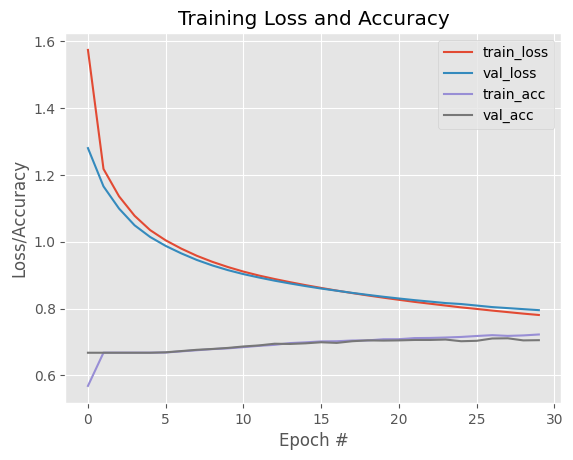

In [79]:
# show accuracy y losses graphs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history1["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history1["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), history1["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history1["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### **Train Deep Net** - Second attempt with different hyperparameters


Added Dropout layers to reduce overfitting and implemented EarlyStopping to avoid unnecessary training.


In [51]:
batch_size = 32
dropout_rates = [0.5, 0.3]
hidden_layers = [128, 64, 32]
learning_rate = 1e-3
name='image_model_2'
num_epochs = 30

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    restore_best_weights=True
)

In [52]:
model2, H2 = train_deep_net(
    name=name,
    activation_function=tf.nn.relu,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    hidden_layers=hidden_layers,
    dropout_rates=dropout_rates,
    x_train=X_train,
    x_val=X_val,
    x_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    callbacks=[early_stop]
)

[INFO]: Training the Neural Network...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3202 - loss: 1.8441 - val_accuracy: 0.6683 - val_loss: 1.3304
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6730 - loss: 1.2417 - val_accuracy: 0.6683 - val_loss: 1.1387
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6579 - loss: 1.1429 - val_accuracy: 0.6683 - val_loss: 1.0693
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6689 - loss: 1.0577 - val_accuracy: 0.6683 - val_loss: 1.0198
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6710 - loss: 0.9998 - val_accuracy: 0.6690 - val_loss: 0.9872
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6678 - loss: 0.9761 - val_accuracy: 0.6683 - val_loss: 0.9649
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6676 - loss: 0.9555 - val_accuracy: 0.6746 - val_loss: 0.9483
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0

In [53]:
test_loss2, test_acc2 = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc2:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7061 - loss: 0.8509
Test accuracy: 0.71


In [54]:
# save the model
# save_model(model2, PATH_IMAGE_MODEL2)

In [55]:
# save history object
# with open("history2.pkl", "wb") as f:
#   pickle.dump(H2.history, f)

In [56]:
model2_saved = load_model(PATH_IMAGE_MODEL2, compile=False)

In [57]:
# load history object
with open("history2.pkl", "rb") as f:
  history2 = pickle.load(f)

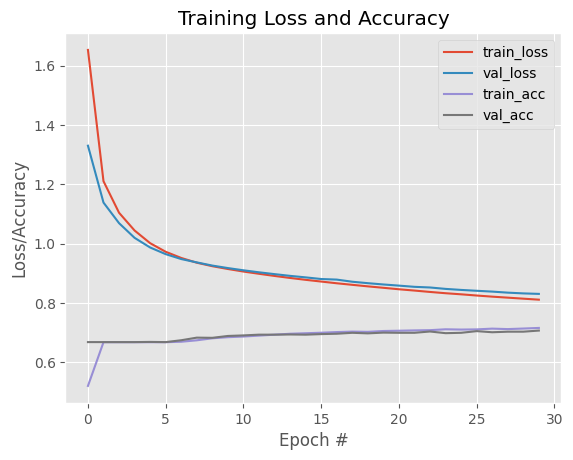

In [58]:
# show accuracy y losses graphs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history2["loss"])), history2["loss"], label="train_loss")
plt.plot(np.arange(0, len(history2["val_loss"])), history2["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(history2["accuracy"])), history2["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(history2["val_accuracy"])), history2["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()



### **Train Deep Net** - Third attempt

In [59]:
batch_size = 32
dropout_rates = [0.5, 0.3]
hidden_layers = [256, 128, 64, 32]
learning_rate = 1e-3
name='image_model_3'
num_epochs = 30

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=3,
    restore_best_weights=True,
    mode='auto'
)

In [60]:
model3, H3 = train_deep_net(
    name=name,
    activation_function=tf.nn.relu,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs,
    hidden_layers=hidden_layers,
    dropout_rates=dropout_rates,
    x_train=X_train,
    x_val=X_val,
    x_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    callbacks=[early_stop]
)

[INFO]: Training the Neural Network...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6653 - loss: 1.4996 - val_accuracy: 0.6683 - val_loss: 1.1566
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6678 - loss: 1.1410 - val_accuracy: 0.6683 - val_loss: 1.0847
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6759 - loss: 1.0609 - val_accuracy: 0.6683 - val_loss: 1.0347
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6797 - loss: 1.0013 - val_accuracy: 0.6683 - val_loss: 1.0024
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6690 - loss: 0.9926 - val_accuracy: 0.6683 - val_loss: 0.9770
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6654 - loss: 0.9815 - val_accuracy: 0.6677 - val_loss: 0.9540
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6806 - loss: 0.9281 - val_accuracy: 0.6696 - val_loss: 0.9364
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

In [61]:
# accuracy test set
test_loss3, test_acc3 = model3.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc3:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7092 - loss: 0.8396
Test accuracy: 0.72


In [64]:
# save the model
# save_model(model3, PATH_IMAGE_MODEL3)

In [65]:
# save history object
# with open("history3.pkl", "wb") as f:
#   pickle.dump(H3.history, f)

In [66]:
model3_saved = load_model(PATH_IMAGE_MODEL3, compile=False)

In [70]:
# load history object
with open("history3.pkl", "rb") as f:
  history3 = pickle.load(f)

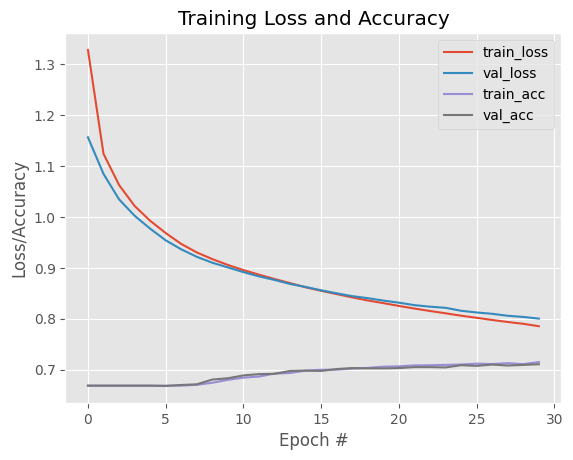

In [71]:
# show accuracy y losses graphs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history3["loss"])), history3["loss"], label="train_loss")
plt.plot(np.arange(0, len(history3["val_loss"])), history3["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(history3["accuracy"])), history3["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(history3["val_accuracy"])), history3["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()



**Note:**

As you have seen, I 've attempted three times with the intention to get a better hyperparameter each time, but it'd make sense to apply some hyperparameter optimization technique, as we saw in class, e.g. Hyperopt, but I'll leave it for later in case I have time to revisit this problem.